In [1]:
pip install pandas numpy matplotlib scikit-learn yfinance tensorflow


In [2]:
# 📌 Step 1: Import Libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [6]:
# 📌 Step 2: Download Stock Data
ticker = 'AAPL'
df = yf.download(ticker, start='2015-01-01', end='2025-07-30')

/tmp/ipython-input-6-2289118379.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2015-01-01', end='2025-07-30')
[*********************100%***********************]  1 of 1 completed


In [7]:
# 📌 Step 3: Add Technical Indicators
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(price):
    ema12 = price.ewm(span=12).mean()
    ema26 = price.ewm(span=26).mean()
    macd = ema12 - ema26
    signal = macd.ewm(span=9).mean()
    return macd, signal

df['Return'] = df['Close'].pct_change()
df['SMA_10'] = df['Close'].rolling(10).mean()
df['SMA_50'] = df['Close'].rolling(50).mean()
df['RSI'] = compute_rsi(df['Close'])
df['MACD'], df['MACD_signal'] = compute_macd(df['Close'])

In [41]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Step 1: Download historical stock data using yfinance
ticker = 'AAPL'  # You can change this to any valid stock symbol
start_date = '2020-01-01'
end_date = '2024-12-31'

df = yf.download(ticker, start=start_date, end=end_date)
df.reset_index(inplace=True)

# Step 2: Feature Engineering

# Daily Return
df['Return'] = df['Close'].pct_change()

# Simple Moving Averages
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# RSI (Relative Strength Index)
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

df['RSI'] = compute_rsi(df['Close'])

# MACD and MACD Signal
ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Future Close price (next day's close)
df['Future_Close'] = df['Close'].shift(-1)

# Step 3: Drop rows with NaNs in any feature column
feature_cols = ['Return', 'SMA_10', 'SMA_50', 'RSI', 'MACD', 'MACD_signal', 'Future_Close']
#df.dropna(subset=feature_cols, inplace=True)
df.reset_index(drop=True, inplace=True)

# Step 4: Scale Features
features = ['Return', 'SMA_10', 'SMA_50', 'RSI', 'MACD', 'MACD_signal']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

# Step 5: Create final dataframe with scaled features and target
scaled_df = pd.DataFrame(scaled_features, columns=features)
scaled_df['Future_Close'] = df['Future_Close'].values

# Step 6: Output preview
print(scaled_df.head())


/tmp/ipython-input-41-549812206.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

     Return  SMA_10  SMA_50  RSI      MACD  MACD_signal  Future_Close
0       NaN     NaN     NaN  NaN -0.339581    -0.357112     71.914818
1 -0.546781     NaN     NaN  NaN -0.359903    -0.361470     72.487854
2  0.339756     NaN     NaN  NaN -0.359099    -0.364784     72.146919
3 -0.295275     NaN     NaN  NaN -0.368060    -0.369357     73.307510
4  0.746597     NaN     NaN  NaN -0.341350    -0.367287     74.864616


In [42]:
print("Columns in df:", df.columns.tolist())

expected_cols = ['Return', 'SMA_10', 'SMA_50', 'RSI', 'MACD', 'MACD_signal', 'Future_Close']
missing_cols = [col for col in expected_cols if col not in df.columns]
print("Missing columns:", missing_cols)



Columns in df: [('Date', ''), ('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL'), ('Return', ''), ('SMA_10', ''), ('SMA_50', ''), ('RSI', ''), ('MACD', ''), ('MACD_signal', ''), ('Future_Close', '')]
Missing columns: []


In [43]:
for col in expected_cols:
    assert col in df.columns, f"Missing expected column: {col}"


In [44]:
print(f"Number of rows before scaling: {len(df)}")
print(df[features].isnull().sum())  # Check if columns have NaNs
print(df[features].head())


Number of rows before scaling: 1257
Price        Ticker
Return                  1
SMA_10                  9
SMA_50                 49
RSI                    14
MACD                    0
MACD_signal             0
dtype: int64
Price     Return SMA_10 SMA_50 RSI      MACD MACD_signal
Ticker                                                  
0            NaN    NaN    NaN NaN  0.000000    0.000000
1      -0.009722    NaN    NaN NaN -0.056320   -0.011264
2       0.007968    NaN    NaN NaN -0.054092   -0.019830
3      -0.004703    NaN    NaN NaN -0.078927   -0.031649
4       0.016086    NaN    NaN NaN -0.004902   -0.026300


In [45]:
print("Rows with any NaN in features:", df[features].isnull().any(axis=1).sum())


Rows with any NaN in features: 49


In [46]:
df.fillna(method='ffill', inplace=True)  # forward fill
# or
df.fillna(df.mean(), inplace=True)  # fill numeric NaNs with mean


/tmp/ipython-input-46-2385214881.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # forward fill


In [47]:
features = ['Return', 'SMA_10', 'SMA_50', 'RSI', 'MACD', 'MACD_signal']

print("DataFrame shape:", df.shape)
print("Columns available:", df.columns.tolist())

# Check if feature columns exist
missing = [f for f in features if f not in df.columns]
print("Missing features:", missing)

# Check rows and nulls in those columns
print("Number of rows with no NaNs in features:", df[features].dropna().shape[0])

print(df[features].head())


DataFrame shape: (1257, 13)
Columns available: [('Date', ''), ('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL'), ('Return', ''), ('SMA_10', ''), ('SMA_50', ''), ('RSI', ''), ('MACD', ''), ('MACD_signal', ''), ('Future_Close', '')]
Missing features: []
Number of rows with no NaNs in features: 1257
Price     Return      SMA_10      SMA_50        RSI      MACD MACD_signal
Ticker                                                                   
0       0.001189  151.815511  151.626678  54.977008  0.000000    0.000000
1      -0.009722  151.815511  151.626678  54.977008 -0.056320   -0.011264
2       0.007968  151.815511  151.626678  54.977008 -0.054092   -0.019830
3      -0.004703  151.815511  151.626678  54.977008 -0.078927   -0.031649
4       0.016086  151.815511  151.626678  54.977008 -0.004902   -0.026300


In [48]:
# 📌 Step 5: Drop NaNs and Define Features
#df.dropna(inplace=True)

features = ['Return', 'SMA_10', 'SMA_50', 'RSI', 'MACD', 'MACD_signal']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

In [49]:
# Create a basic trading signal based on SMA crossover
df['Signal'] = 0
df.loc[df['SMA_10'] > df['SMA_50'], 'Signal'] = 1
df.loc[df['SMA_10'] < df['SMA_50'], 'Signal'] = -1


In [50]:
# 📌 Step 6: Build Sequences for LSTM
def create_sequences(X, y, window=20):
    X_seq, y_seq = [], []
    for i in range(window, len(X)):
        X_seq.append(X[i-window:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

X, y = create_sequences(scaled_features, df['Signal'].values)




In [51]:
# 📌 Step 7: Train-Test Split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]



In [52]:
# 📌 Step 8: Build and Train LSTM Model
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes: Sell (-1), Hold (0), Buy (1)
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [53]:
# Convert y to 0, 1, 2 for classification
label_map = {-1: 0, 0: 1, 1: 2}
y_train_mapped = np.vectorize(label_map.get)(y_train)
y_test_mapped = np.vectorize(label_map.get)(y_test)

model.fit(X_train, y_train_mapped, epochs=10, batch_size=32, validation_split=0.1)



Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5723 - loss: 0.9414 - val_accuracy: 0.9091 - val_loss: 0.3764
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9223 - loss: 0.2858 - val_accuracy: 0.9394 - val_loss: 0.2005
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9455 - loss: 0.1461 - val_accuracy: 0.9394 - val_loss: 0.1513
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9539 - loss: 0.0998 - val_accuracy: 0.9495 - val_loss: 0.1337
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9620 - loss: 0.1098 - val_accuracy: 0.9697 - val_loss: 0.1424
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9749 - loss: 0.0831 - val_accuracy: 0.9596 - val_loss: 0.1141
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9659 - loss: 0.0891 - val_accuracy: 0.9798 - val_loss: 0.1294
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9784 - loss: 0.0648 - val_accuracy: 0.9697 - v

In [54]:
# 📌 Step 9: Evaluate
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Classification Report:\n", classification_report(y_test_mapped, y_pred))



8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.98      0.89        98
           2       0.98      0.85      0.91       150

    accuracy                           0.90       248
   macro avg       0.90      0.92      0.90       248
weighted avg       0.92      0.90      0.90       248



In [55]:
# Convert predictions back to -1, 0, 1
reverse_map = {0: -1, 1: 0, 2: 1}
y_pred_final = np.vectorize(reverse_map.get)(y_pred)



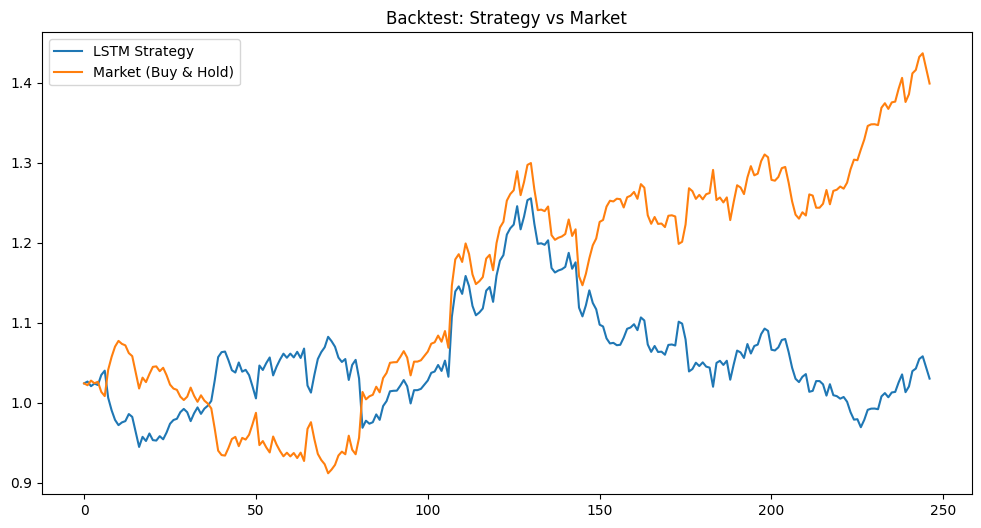

In [56]:
# 📌 Step 10: Backtest Strategy
returns = df['Return'].values[-len(y_pred_final):]
# strategy_returns = returns * y_pred_final[:-1]  # Shift predictions

# cumulative_strategy = (1 + strategy_returns).cumprod()
# cumulative_market = (1 + returns).cumprod()
# Use today’s signal for tomorrow’s return
strategy_returns = returns[1:] * y_pred_final[:-1]
cumulative_strategy = (1 + strategy_returns).cumprod()

# For comparison: market (buy-and-hold) strategy
cumulative_market = (1 + returns[1:]).cumprod()


plt.figure(figsize=(12,6))
plt.plot(cumulative_strategy, label='LSTM Strategy')
plt.plot(cumulative_market, label='Market (Buy & Hold)')
plt.legend()
plt.title("Backtest: Strategy vs Market")
plt.show()